# Data vizualisation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
path_to_module_1 = '/content/drive/My Drive/LandCover_map_Transformers_SSL/src'
sys.path.append(path_to_module_1)


In [ ]:
'''!pip install matplotlib==3.5.2
!pip install scikit-image==0.19.3
!pip install pillow==9.3.0
!pip install pytorch==1.12.1
!pip install torchmetrics==0.10.0
!pip install pytorch-lightning==1.8
!pip install segmentation-models-pytorch==0.3.0
!pip install albumentations==1.2.1
!pip install rasterio
!pip install tensorboard==2.10.1'''

'!pip install matplotlib==3.5.2\n!pip install scikit-image==0.19.3\n!pip install pillow==9.3.0\n!pip install pytorch==1.12.1\n!pip install torchmetrics==0.10.0\n!pip install pytorch-lightning==1.8\n!pip install segmentation-models-pytorch==0.3.0\n!pip install albumentations==1.2.1\n!pip install rasterio\n!pip install tensorboard==2.10.1'

In [ ]:
from pathlib import Path
from py_module.data_display import (get_data_paths,
                                   display_nomenclature,
                                   display_samples,
                                   display_all_with_semantic_class,
                                   display_all)

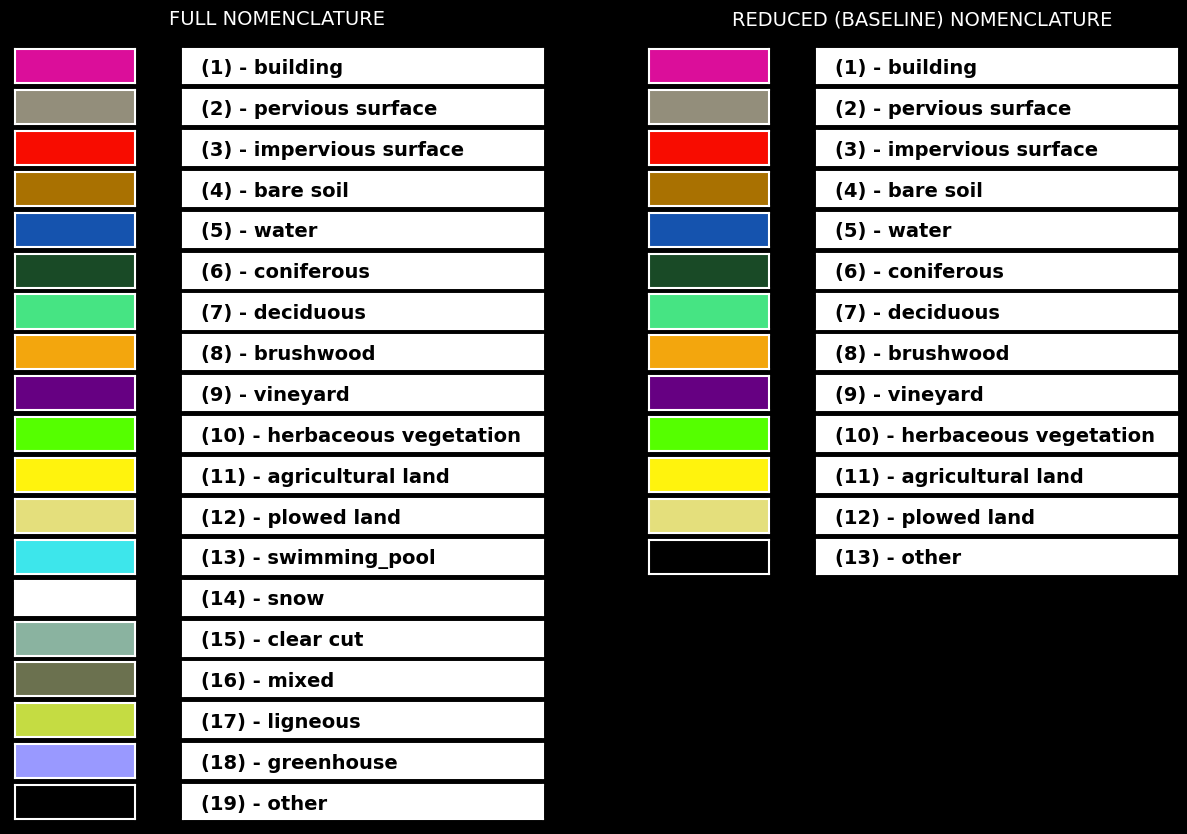

In [ ]:
display_nomenclature()

In [ ]:
path_toy_dataset_folder = '/content/drive/My Drive/flair1_fullset_13classes/train'
sys.path.append(path_toy_dataset_folder)

images = sorted(list(get_data_paths(Path(path_toy_dataset_folder), 'image*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
masks  = sorted(list(get_data_paths(Path(path_toy_dataset_folder), 'mask*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))

In [ ]:
display_samples(images, masks, nb_samples=4)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#display_all_with_semantic_class(images, masks, semantic_class=1)

In [ ]:
#display_all(images, masks)

# Built Swin Transformer model

In [ ]:
#general
import os
import numpy as np
import json
import random
from pathlib import Path

#deep learning
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.callbacks.progress.tqdm_progress import TQDMProgressBar
from pytorch_lightning import Trainer, seed_everything

import albumentations as A

#flair-one baseline modules
from py_module.utils import load_data, step_loading, print_recap, print_metrics
from py_module.datamodule import OCS_DataModule
from py_module.model import SMP_Unet_meta
from py_module.task_module import SegmentationTask
from py_module.writer import PredictionWriter

In [ ]:
config = {

    ############################
    # PATHS
    ############################

    'data': {
              'path_aerial_train': "/content/drive/My Drive/flair1_fullset_13classes/train",
              'path_aerial_test':  "/content/drive/My Drive/flair1_fullset_13classes/test",

              'path_aerial_val': "/content/drive/My Drive/flair1_fullset_13classes/val",


              'path_metadata_aerial': "./flair-1_metadata_aerial.json", #e.g., ./flair-1_metadata_aerial.json
            },

    ############################
    # NAMINGS
    ############################
    'outputs': {
                  'out_folder': "/content/drive/My Drive/LandCover_map_Transformers_SSL/src/results",
                  'out_model_name': "resnetUnet",
               },


    ############################
    # CLASSES
    ############################
    'num_classes': 13,

    ############################
    # TASKING
    ############################
    'use_weights': True,
    'class_weights': [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0],
    'use_metadata': False,
    'use_augmentation': False,


    ############################
    # TRAINING
    ############################
    'batch_size': 5,
    'learning_rate': 0.02,
    'num_epochs': 100,

    ############################
    # COMPUTATIONAL
    ############################
    'accelerator': 'gpu',
    'strategy':  None,#e.g., 'ddp' if multiple GPUs otherwise leave emtpy if single GPU training
    'num_nodes': 1,
    'gpus_per_node': 1,
    'num_workers': 1,

    ############################
    # PRINTS TRAINING
    ############################
    'enable_progress_bar': True,
    'progress_rate': 10,


}

In [ ]:
out_dir = Path(config['outputs']["out_folder"], config['outputs']["out_model_name"])
out_dir.mkdir(parents=True, exist_ok=True)
seed_everything(2022, workers=True)

dict_train, dict_val, dict_test = step_loading(config["data"], use_metadata=config["use_metadata"])
print_recap(config, dict_train, dict_val, dict_test)

if config['use_augmentation'] == True:
    transform_set = A.Compose([A.VerticalFlip(p=0.5),
                               A.HorizontalFlip(p=0.5),
                               A.RandomRotate90(p=0.5)])
else:
    transform_set = None

dm = OCS_DataModule(
    dict_train = dict_train,
    dict_val = dict_val,
    dict_test = dict_test,
    batch_size = config["batch_size"],
    num_workers = config["num_workers"],
    drop_last = True,
    num_classes = config["num_classes"],
    num_channels = 5,
    use_metadata = config["use_metadata"],
    use_augmentations = transform_set)

INFO:lightning_lite.utilities.seed:Global seed set to 2022


+-----------------------------+    LOADING DATA    +-----------------------------+

+================================================================================+
Model name: resnetUnet
+================================================================================+
[---TASKING---]
- use weights              :    True
- use metadata             :    False
- use augmentation         :    False

+--------------------------------------------------------------------------------+
[---DATA SPLIT---]
- train                    :    1664 samples
- val                      :    416 samples
- test                     :    520 samples

+--------------------------------------------------------------------------------+
[---HYPER-PARAMETERS---]
- batch size               :    5
- learning rate            :    0.02
- epochs                   :    100
- nodes                    :    1
- GPU per nodes            :    1
- accelerator              :    gpu
- workers                  :    1

+------

In [ ]:
model = SMP_Unet_meta(n_channels=5, n_classes=13, use_metadata=config['use_metadata'])

In [ ]:
if config['use_weights'] == True:
    with torch.no_grad():
        class_weights = torch.FloatTensor(config['class_weights'])
    criterion = nn.CrossEntropyLoss(weight=class_weights)
else:
    criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'])

In [ ]:
scheduler = ReduceLROnPlateau(
    optimizer=optimizer,
    mode="min",
    factor=0.5,
    patience=10,
    cooldown=4,
    min_lr=1e-7,
)

In [ ]:
seg_module = SegmentationTask(
    model=model,
    num_classes=dm.num_classes,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    use_metadata=config['use_metadata']
)

In [ ]:
ckpt_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=os.path.join(out_dir,"checkpoints"),
    filename="ckpt-{epoch:02d}-{val_loss:.2f}"+'_'+config['outputs']['out_model_name'],
    save_top_k=1,
    mode="min",
    save_weights_only=True, # can be changed accordingly
)

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=30, # if no improvement after 30 epoch, stop learning.
    mode="min",
)

prog_rate = TQDMProgressBar(refresh_rate=config['progress_rate'])

callbacks = [
    ckpt_callback,
    early_stop_callback,
    prog_rate,
]

In [ ]:
logger = TensorBoardLogger(
    save_dir=out_dir,
    name=Path("tensorboard_logs"+'_'+config['outputs']['out_model_name']).as_posix()
)

loggers = [
    logger
]

In [ ]:
#### instanciation of  Trainer
trainer = Trainer(
    accelerator = config["accelerator"],
    devices = config["gpus_per_node"],
    strategy = config["strategy"],
    num_nodes = config["num_nodes"],
    max_epochs = config["num_epochs"],
    num_sanity_val_steps = 0,
    callbacks = callbacks,
    logger = loggers,
    enable_progress_bar = config["enable_progress_bar"],
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(seg_module, datamodule=dm)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:606: UserWarning: Checkpoint directory /content/drive/My Drive/LandCover_map_Transformers_SSL/src/results/resnetUnet/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params
---------------------------------------------------------
0 | model         | SMP_Unet_meta          | 24.4 M
1 | criterion     | CrossEntropyLoss       | 0     
2 | train_metrics | MulticlassJaccardIndex | 0     
3 | val_metrics   | MulticlassJaccardIndex | 0     
4 | train_loss    | MeanMetric             | 0     
5 | val_loss      | MeanMetric             | 0     
---------------------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    To

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
writer_callback = PredictionWriter(
    output_dir = os.path.join(out_dir, "predictions"+"_"+config['outputs']["out_model_name"]),
    write_interval="batch",
)

#### instanciation of prediction Trainer
trainer = Trainer(
    accelerator = config["accelerator"],
    devices = config["gpus_per_node"],
    strategy = config["strategy"],
    num_nodes = config["num_nodes"],
    callbacks = [writer_callback],
    enable_progress_bar = config["enable_progress_bar"],
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
try:
    from pytorch_lightning.utilities.distributed import rank_zero_only
except ImportError:
    from pytorch_lightning.utilities.rank_zero import rank_zero_only

In [ ]:
trainer.predict(seg_module, datamodule=dm, return_predictions=False)

@rank_zero_only
def print_finish():
    print('--  [FINISHED.]  --', f'output dir : {out_dir}', sep='\n')
print_finish()

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

--  [FINISHED.]  --
output dir : /content/drive/My Drive/LandCover_map_Transformers_SSL/src/results/resnetUnet


In [29]:
from py_module.data_display import display_predictions, get_data_paths

images_test = sorted(list(get_data_paths(Path(config['data']['path_aerial_test']), 'image*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
predictions = sorted(list(get_data_paths(Path(os.path.join(out_dir, "predictions"+"_"+config['outputs']["out_model_name"])), 'image*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


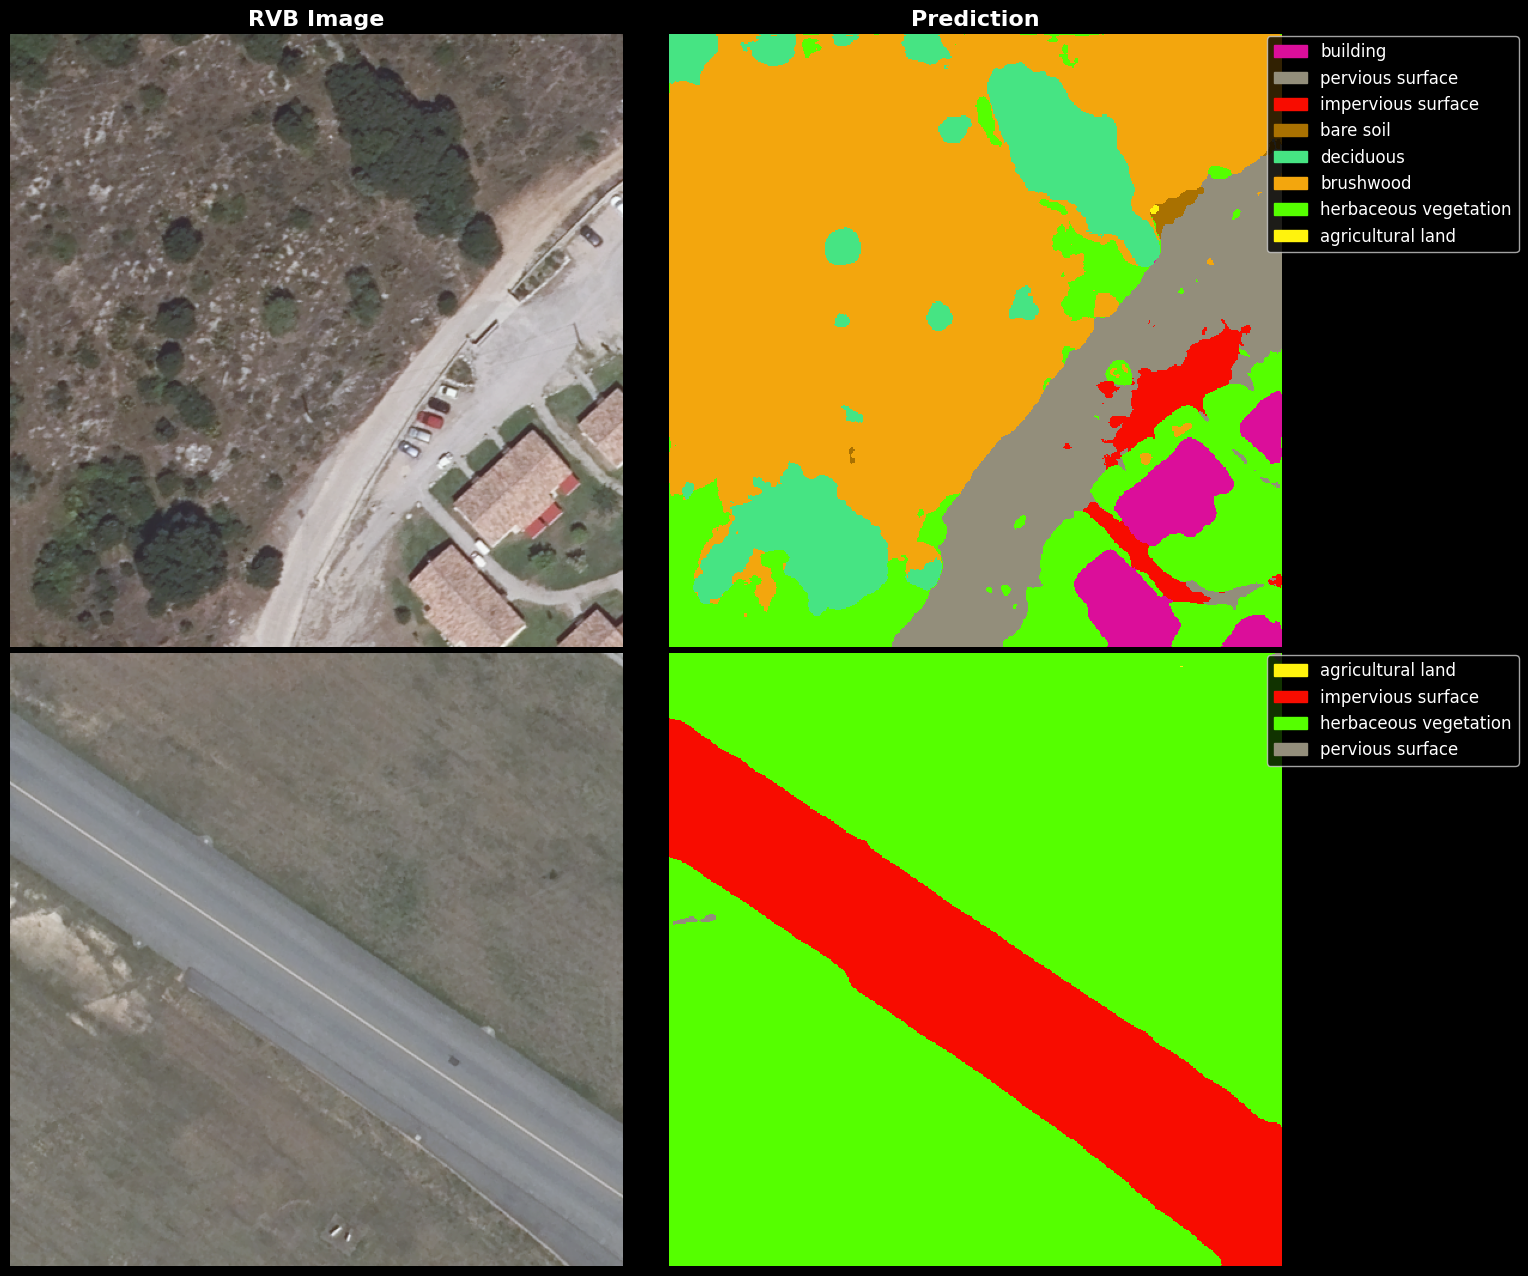

In [30]:
display_predictions(images_test, predictions, nb_samples=2)

In [31]:
import re
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix


def generate_miou(path_truth: str, path_pred: str) -> list:

    #################################################################################################
    def get_data_paths (path, filter):
        for path in Path(path).rglob(filter):
             yield path.resolve().as_posix()

    def calc_miou(cm_array):
        m = np.nan
        with np.errstate(divide='ignore', invalid='ignore'):
            ious = np.diag(cm_array) / (cm_array.sum(0) + cm_array.sum(1) - np.diag(cm_array))
        m = np.nansum(ious[:-1]) / (np.logical_not(np.isnan(ious[:-1]))).sum()
        return m.astype(float), ious[:-1]

    #################################################################################################

    truth_images = sorted(list(get_data_paths(Path(path_truth), 'mask*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
    preds_images  = sorted(list(get_data_paths(Path(path_pred), 'image*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
    if len(truth_images) != len(preds_images):
        print('[WARNING !] mismatch number of predictions and test files.')

    patch_confusion_matrices = []

    for u in range(len(truth_images)):
        target = np.array(Image.open(truth_images[u]))-1 # -1 as model predictions start at 0 and turth at 1.
        target[target>12]=12  ### remapping masks to reduced baseline nomenclature.
        preds = np.array(Image.open(preds_images[u]))
        patch_confusion_matrices.append(confusion_matrix(target.flatten(), preds.flatten(), labels=list(range(13))))

    sum_confmat = np.sum(patch_confusion_matrices, axis=0)
    mIou, ious = calc_miou(sum_confmat)

    return mIou, ious

In [32]:
truth_msk = config['data']['path_aerial_test']
pred_msk  = os.path.join(out_dir, "predictions"+"_"+config['outputs']["out_model_name"])
mIou, ious = generate_miou(truth_msk, pred_msk)
print_metrics(mIou, ious)



----------------------------------------
         Model mIoU :  0.6898
----------------------------------------
Class                     iou            
----------------------------------------
building                  0.788606382955834
pervious surface          0.4008942260759313
impervious surface        0.7403959052534707
bare soil                 0.5896600863100939
water                     0.919350262268876
coniferous                0.6546771155211211
deciduous                 0.7676346420166753
brushwood                 0.5234844547838946
vineyard                  0.9118170652764569
herbaceous vegetation     0.7101928554811903
agricultural land         0.6890465137884447
plowed land               0.5820105849523322



